# DistilBERT

### Installs and imports

In [ ]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import seaborn as sns
import string
import time
import torch
import torch.optim as optim
import torch.nn.functional as F

from datasets import load_dataset
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, ConfusionMatrixDisplay, matthews_corrcoef
from torch.nn import CosineEmbeddingLoss
from torch.utils.data import DataLoader
from transformers import (
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BertForSequenceClassification,
    BertTokenizer,
    DataCollatorForLanguageModeling,
    DataCollatorWithPadding,
    DistilBertConfig,
    TrainingArguments,
    Trainer
)
from tqdm import tqdm

save_path = "/content/drive/MyDrive/CS4782FinalProject/final_train"
save_model_folder_name = "final_distilled_student_model_wikitext"
model_path = os.path.join(save_path, save_model_folder_name)
checkpoint_path = os.path.join(save_path, "checkpoint.pth")

# Distillation using Masked Language Modelling

In [ ]:
class DistilBertConfig:
    teacher_model = "bert-base-uncased"
    student_model = "distilbert-base-uncased"

    device = "cuda" if torch.cuda.is_available() else "cpu"

    batch_size = 16
    learning_rate = 5e-5
    epochs = 10
    max_len = 128
    mlm_prob = 0.15

config = DistilBertConfig()

In [ ]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
tokenizer = AutoTokenizer.from_pretrained(config.teacher_model)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=config.max_len)

tokenized_dataset = {
    split: dataset[split].map(tokenize_function, batched=True, remove_columns=["text"])
    for split in ["train", "validation", "test"]
}

for split in tokenized_dataset:
    tokenized_dataset[split].set_format(type="torch", columns=["input_ids", "attention_mask"])

# Data collator will mask tokens for us
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=config.mlm_prob)

train_loader = DataLoader(tokenized_dataset["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(tokenized_dataset["validation"], batch_size=config.batch_size, shuffle=False, collate_fn=data_collator)
test_loader = DataLoader(tokenized_dataset["test"], batch_size=config.batch_size, shuffle=False, collate_fn=data_collator)

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [ ]:
teacher = AutoModelForMaskedLM.from_pretrained(config.teacher_model).to(config.device)
teacher.eval()

student = AutoModelForMaskedLM.from_pretrained(config.student_model).to(config.device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
def copy_every_other_layer(student, teacher):
    """
    Copy every other teacher layer into the student.
    Assumes student has half as many encoder layers as teacher.
    """
    teacher_layers = teacher.bert.encoder.layer
    student_layers = student.distilbert.transformer.layer

    # Copy every other teacher layer into student
    for i, layer in enumerate(student_layers):
        teacher_layer = teacher_layers[i * 2]
        layer.load_state_dict(teacher_layer.state_dict(), strict=False)

copy_every_other_layer(student, teacher)

In [ ]:
def distill_loss(student_logits,
                 teacher_logits,
                 student_hidden,
                 teacher_hidden,
                 labels,
                 temperature=2.0,
                 alpha=0.5,
                 beta=0.5,
                 gamma=1.0):

    cosine_loss_fn = CosineEmbeddingLoss()

    # Only compute loss on masked tokens
    mask = labels != -100
    if mask.sum() == 0:
      print("mask sum is 0")
      return torch.tensor(0.0, device=student_logits.device, requires_grad=True)

    #### MLM Loss ####
    ce_loss = F.cross_entropy(student_logits.view(-1, student_logits.size(-1)), labels.view(-1), ignore_index=-100)

    # KL divergence between softened predictions
    student_probs = F.log_softmax(student_logits / temperature, dim=-1)
    teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)

    kl_loss = F.kl_div(
        student_probs,
        teacher_probs,
        reduction="batchmean"
    ) * (temperature ** 2)

    # Cosine embedding loss on hidden states
    # Cosine embedding loss between intermediate hidden states
    losses = []
    teacher_layers = teacher_hidden[1::2]  # take every 2nd layer starting from index 1
    student_layers = student_hidden[1:]    # skip the student input embedding layer

    for t, s in zip(teacher_layers, student_layers):
        # Flatten hidden state in vectors of HIDDEN_STATE_SIZE for every token
        # in the batch (B, SEQ_LEN, HIDDEN_STATE_SIZE) -> (B x SEQ_LEN, HIDDEN_STATE_SIZE)
        t_flat = t.reshape(-1, t.size(-1))
        s_flat = s.reshape(-1, s.size(-1))

        # Create a tensor of ones (B x SEQ_LEN) as the target cosine similarity
        # between teacher and student hidden states
        target = torch.ones(t_flat.size(0)).to(t.device)
        losses.append(cosine_loss_fn(s_flat, t_flat, target))

    cos_loss = torch.stack(losses).mean()

    total_loss = alpha * ce_loss + beta * kl_loss + gamma * cos_loss
    return total_loss, {
        "ce_loss": ce_loss.item(),
        "kd_loss": kl_loss.item(),
        "cos_loss": cos_loss.item()
    }

In [ ]:
optimizer = optim.AdamW(student.parameters(), lr=config.learning_rate)

In [ ]:
# Save a training checkpoint (for resuming training later)
def save_checkpoint(model, optimizer, epoch, path):
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)
    print(f"Checkpoint saved to {path}")

start_epoch = 0
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=config.device)
    student.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from epoch {start_epoch}")
else:
    print("Starting training from scratch")

Loading checkpoint from /content/drive/MyDrive/CS4782FinalProject/final_train/checkpoint.pth
Resumed from epoch 10


In [ ]:
train_losses = []
eval_accuracies = []
epochs_times = []
start_time = time.time()

try:
    for epoch in range(start_epoch, config.epochs):
        student.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(config.device)
            attention_mask = batch["attention_mask"].to(config.device)
            labels = batch["labels"].to(config.device)

            # Teacher outputs
            with torch.no_grad():
                teacher_outputs = teacher(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True
                )
                teacher_logits = teacher_outputs.logits
                teacher_hidden_states = teacher_outputs.hidden_states

            # Student outputs
            student_outputs = student(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )
            student_logits = student_outputs.logits
            student_hidden_states = student_outputs.hidden_states

             # Compute distillation loss (returns total_loss, loss_dict)
            loss, loss_dict = distill_loss(
                student_logits, teacher_logits,
                student_hidden_states, teacher_hidden_states,
                labels, temperature=2.0, alpha=0.5, beta=0.5, gamma=1.0
            )

            if torch.isnan(loss) or torch.isinf(loss):
                print("Skipping batch due to NaN/Inf loss")
                continue

            # Update model
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        # Track training loss
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation evaluation
        student.eval()
        correct = 0
        total_masked = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(config.device)
                attention_mask = batch["attention_mask"].to(config.device)
                labels = batch["labels"].to(config.device)

                outputs = student(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                predictions = logits.argmax(dim=-1)

                mask = labels != -100
                correct += (predictions[mask] == labels[mask]).sum().item()
                total_masked += mask.sum().item()

        mlm_accuracy = correct / total_masked if total_masked > 0 else 0.0
        eval_accuracies.append(mlm_accuracy)

        # Track timer
        epoch_time = time.time() - start_time
        epochs_times.append(epoch_time)

        # Print metrics
        print(f"Epoch {epoch+1}: Loss={avg_train_loss:.4f}, Acc={mlm_accuracy:.4f}, Time={epoch_time:.2f}s")

        # Save checkpoint after every epoch
        save_checkpoint(student, optimizer, epoch, checkpoint_path)

        # Reset timer for next epoch
        start_time = time.time()

except Exception as e:
    print(f"Exception occurred during training: {e}")
    print("Saving current model and checkpoint...")

    student.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)
    save_checkpoint(student, optimizer, epoch, checkpoint_path)

    print(f"Hugging Face model saved to {model_path}")

Epoch 1: 100%|██████████| 2295/2295 [17:47<00:00,  2.15it/s]


Epoch 1: Loss=35.9883, Acc=0.5663, Time=1088.17s
Checkpoint saved to /content/drive/MyDrive/CS4782FinalProject/final_train/checkpoint.pth


Epoch 2: 100%|██████████| 2295/2295 [17:46<00:00,  2.15it/s]


Epoch 2: Loss=31.5332, Acc=0.5718, Time=1087.68s
Checkpoint saved to /content/drive/MyDrive/CS4782FinalProject/final_train/checkpoint.pth


Epoch 3: 100%|██████████| 2295/2295 [17:47<00:00,  2.15it/s]


Epoch 3: Loss=30.1132, Acc=0.5741, Time=1088.26s
Checkpoint saved to /content/drive/MyDrive/CS4782FinalProject/final_train/checkpoint.pth


Epoch 4: 100%|██████████| 2295/2295 [17:45<00:00,  2.15it/s]


Epoch 4: Loss=29.1048, Acc=0.5755, Time=1086.78s
Checkpoint saved to /content/drive/MyDrive/CS4782FinalProject/final_train/checkpoint.pth


Epoch 5: 100%|██████████| 2295/2295 [17:46<00:00,  2.15it/s]


Epoch 5: Loss=28.4450, Acc=0.5675, Time=1087.84s
Checkpoint saved to /content/drive/MyDrive/CS4782FinalProject/final_train/checkpoint.pth


Epoch 6: 100%|██████████| 2295/2295 [17:48<00:00,  2.15it/s]


Epoch 6: Loss=27.8432, Acc=0.5717, Time=1089.50s
Checkpoint saved to /content/drive/MyDrive/CS4782FinalProject/final_train/checkpoint.pth


Epoch 7: 100%|██████████| 2295/2295 [17:48<00:00,  2.15it/s]


Epoch 7: Loss=27.3745, Acc=0.5735, Time=1089.37s
Checkpoint saved to /content/drive/MyDrive/CS4782FinalProject/final_train/checkpoint.pth


Epoch 8: 100%|██████████| 2295/2295 [17:47<00:00,  2.15it/s]


Epoch 8: Loss=26.8614, Acc=0.5739, Time=1088.18s
Checkpoint saved to /content/drive/MyDrive/CS4782FinalProject/final_train/checkpoint.pth


Epoch 9: 100%|██████████| 2295/2295 [17:46<00:00,  2.15it/s]


Epoch 9: Loss=26.5405, Acc=0.5789, Time=1086.98s
Checkpoint saved to /content/drive/MyDrive/CS4782FinalProject/final_train/checkpoint.pth


Epoch 10: 100%|██████████| 2295/2295 [17:46<00:00,  2.15it/s]


Epoch 10: Loss=26.3709, Acc=0.5736, Time=1087.05s
Checkpoint saved to /content/drive/MyDrive/CS4782FinalProject/final_train/checkpoint.pth


In [ ]:
student.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"Hugging Face model saved to {model_path}")

save_checkpoint(student, optimizer, epoch=epoch, path=checkpoint_path)

Hugging Face model saved to /content/drive/MyDrive/CS4782FinalProject/final_train/final_distilled_student_model_wikitext
Checkpoint saved to /content/drive/MyDrive/CS4782FinalProject/final_train/checkpoint.pth


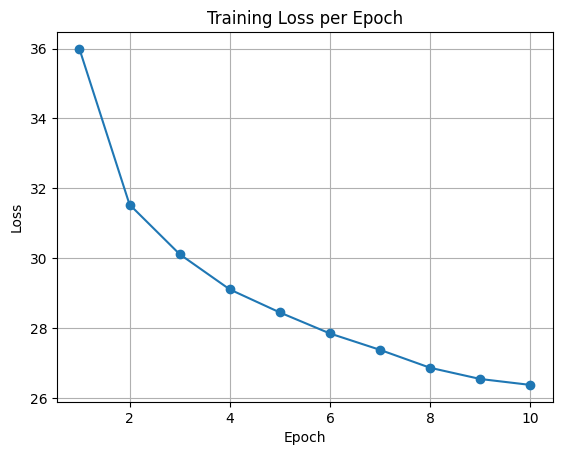

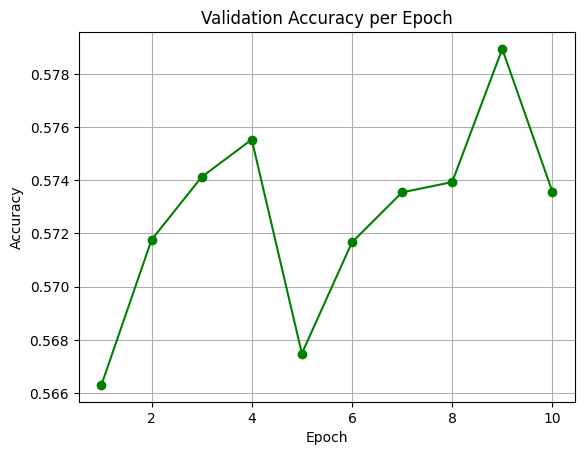

In [ ]:
# Loss curve
loss_path = os.path.join(save_path, "loss_curve.png")

plt.figure()
plt.plot(range(1, config.epochs+1), train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.savefig(loss_path)
plt.show()

# Accuracy curve
accuracy_path = os.path.join(save_path, "accuracy_curve.png")

plt.figure()
plt.plot(range(1, config.epochs+1), eval_accuracies, marker='o', color='green')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.savefig(accuracy_path)
plt.show()

In [ ]:
print(train_losses)
print(eval_accuracies)

[35.98826759479664, 31.533203747069912, 30.11322899321845, 29.104826942975745, 28.445035112917033, 27.843216597904046, 27.37450511865886, 26.861402314628652, 26.540539701623853, 26.370910948086408]
[0.5663068910861198, 0.5717624882186616, 0.574122873061286, 0.5755311521189479, 0.5674876478514748, 0.5716649120168447, 0.5735448152027532, 0.5739312719922138, 0.5789374315598685, 0.5735724469122834]


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

teacher_params = count_parameters(teacher)
student_params = count_parameters(student)
compression_ratio = teacher_params / student_params

print(f"Teacher Params: {teacher_params:,}")
print(f"Student Params: {student_params:,}")
print(f"Compression Ratio: {compression_ratio:.2f}x")

Teacher Params: 109,514,298
Student Params: 66,985,530
Compression Ratio: 1.63x


In [ ]:
## TODO: Add memory comparsion

# Finetuning and Evaluation

In [ ]:
class FineTuningConfig:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 16
    epochs = 3
    learning_rate = 2e-5

config = FineTuningConfig()

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    preds = []
    labels = []
    times = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(config.device)
            attention_mask = batch["attention_mask"].to(config.device)
            batch_labels = batch["labels"].to(config.device)

            start_time = time.time()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            end_time = time.time()
            total_time = end_time - start_time
            times.append(total_time)

            logits = outputs.logits
            preds.append(logits.argmax(dim=-1).cpu())
            labels.append(batch_labels.cpu())

    avg_inference_time = sum(times) / len(times)

    preds = torch.cat(preds)
    labels = torch.cat(labels)

    acc = accuracy_score(labels, preds)
    mcc = matthews_corrcoef(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    conf_matrix = confusion_matrix(labels, preds)
    report = classification_report(labels, preds, digits=4)

    f1_acc_avg = (f1 + acc) / 2

    return {
        "accuracy": acc,
        "matthews_corrcoef": mcc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "f1_acc_avg": f1_acc_avg,
        "confusion_matrix": conf_matrix,
        "report": report,
        "avg_inference_time": avg_inference_time,
    }

## Finetune for IMDb sequence classification

In [ ]:
imdb_path = os.path.join(save_path, "imdb_finetune_final")

In [ ]:
imdb = load_dataset("imdb")

tokenizer = AutoTokenizer.from_pretrained(model_path,local_files_only=True)

def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

encoded_imdb = imdb.map(preprocess, batched=True)
encoded_imdb.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

data_collator = DataCollatorWithPadding(tokenizer)

train_loader = DataLoader(encoded_imdb["train"], shuffle=True, batch_size=config.batch_size, collate_fn=data_collator)
test_loader = DataLoader(encoded_imdb["test"], batch_size=config.batch_size, collate_fn=data_collator)

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
student_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2).to(config.device)

training_args = TrainingArguments(
    output_dir=os.path.join(imdb_path,"results-student"),
    eval_strategy="epoch",
    learning_rate=config.learning_rate,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    num_train_epochs=config.epochs,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir=os.path.join(imdb_path,"logs-student"),
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=encoded_imdb["train"],
    eval_dataset=encoded_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

student_imdb_path = os.path.join(imdb_path,"student_model")
student_model.save_pretrained(student_imdb_path)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/CS4782FinalProject/final_train/final_distilled_student_model_wikitext and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-be5f6e0fb84a>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.256400,0.255415
2,0.173200,0.303184
3,0.123900,0.335312


In [ ]:
teacher_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(config.device)

training_args = TrainingArguments(
    output_dir=os.path.join(imdb_path,"results-teacher"),
    eval_strategy="epoch",
    learning_rate=config.learning_rate,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    num_train_epochs=config.epochs,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir=os.path.join(imdb_path,"logs-teacher"),
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=teacher_model,
    args=training_args,
    train_dataset=encoded_imdb["train"],
    eval_dataset=encoded_imdb["test"],
    tokenizer=tokenizer, # student tokenizer
    data_collator=data_collator,
)

trainer.train()

teacher_imdb_path = os.path.join(imdb_path,"teacher_model")
teacher_model.save_pretrained(teacher_imdb_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-f7633babca03>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.231200,0.214416
2,0.149500,0.273621
3,0.074200,0.325122


## IMDb Evaluation

In [ ]:
imdb_eval_path = os.path.join(imdb_path, "eval")

student_imdb_path = os.path.join(imdb_path,"student_model")
teacher_imdb_path = os.path.join(imdb_path,"teacher_model")

student = AutoModelForSequenceClassification.from_pretrained(student_imdb_path).to(config.device)
teacher = AutoModelForSequenceClassification.from_pretrained(teacher_imdb_path).to(config.device)
tokenizer = AutoTokenizer.from_pretrained(model_path)

student_imdb_results = evaluate_model(student, test_loader)
teacher_imdb_results = evaluate_model(teacher, test_loader)

In [ ]:
################################### Accuracy ###################################

student_imdb_acc = student_imdb_results["accuracy"]
teacher_imdb_acc = teacher_imdb_results["accuracy"]

imdb_acc_retained_pct = 100 * student_imdb_acc / teacher_imdb_acc

print(f"Teacher Accuracy: {teacher_imdb_acc:.4f}")
print(f"Student Accuracy: {student_imdb_acc:.4f}")
print(f"Student retained {imdb_acc_retained_pct:.2f}% of teacher's performance.")

################################################################################

Teacher Accuracy: 0.9237
Student Accuracy: 0.9121
Student retained 98.74% of teacher's performance.


In [ ]:
########################## Speed Up and Inference Time #########################

student_imdb_inference_time = student_imdb_results["avg_inference_time"]
teacher_imdb_inference_time = teacher_imdb_results["avg_inference_time"]

print(f"Student Avg Inference Time: {student_imdb_inference_time*1000:.2f} ms")
print(f"Teacher Avg Inference Time: {teacher_imdb_inference_time*1000:.2f} ms")

imdb_speedup = teacher_imdb_inference_time / student_imdb_inference_time
print(f"Speedup: {imdb_speedup:.2f}x faster")
################################################################################

Student Avg Inference Time: 4.75 ms
Teacher Avg Inference Time: 9.54 ms
Speedup: 2.01x faster


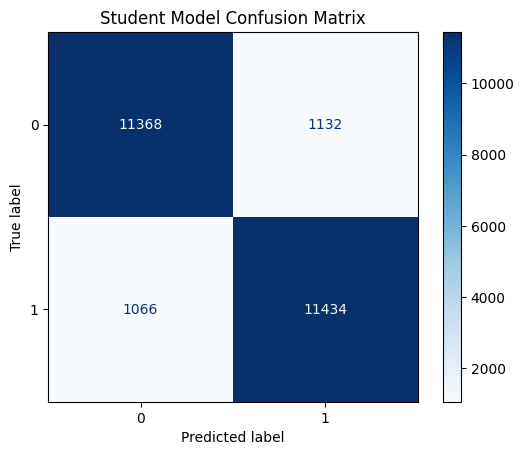

Classification Report:

              precision    recall  f1-score   support

           0     0.9143    0.9094    0.9118     12500
           1     0.9099    0.9147    0.9123     12500

    accuracy                         0.9121     25000
   macro avg     0.9121    0.9121    0.9121     25000
weighted avg     0.9121    0.9121    0.9121     25000

| Model   |   accuracy |   precision |   recall |       f1 |   avg_inference_time |
|:--------|-----------:|------------:|---------:|---------:|---------------------:|
| Student |    0.91208 |    0.909916 |  0.91472 | 0.912311 |           0.00474815 |
| Teacher |    0.92372 |    0.924501 |  0.9228  | 0.92365  |           0.0095408  |
Saved CSV to /content/drive/MyDrive/CS4782FinalProject/final_train/imdb_finetune_final/eval/imdb_comparison.csv


In [ ]:
###################### Student Confusion Matrix and Report #####################

student_imdb_confusion_matrix = student_imdb_results["confusion_matrix"]
student_imdb_report = student_imdb_results["report"]
imdb_cm_matrix_path = os.path.join(imdb_eval_path, "imdb_confusion_matrix.png")
os.makedirs(os.path.dirname(imdb_cm_matrix_path), exist_ok=True)

disp = ConfusionMatrixDisplay(confusion_matrix=student_imdb_confusion_matrix)
disp.plot(cmap="Blues")
plt.title("Student Model Confusion Matrix")
plt.savefig(imdb_cm_matrix_path)
plt.show()

print("Classification Report:\n")
print(student_imdb_report)

classification_report_path = os.path.join(imdb_eval_path, "student_classification_report_imdb.txt")
with open(classification_report_path, "w") as f:
    f.write(student_imdb_report)

################################################################################

################################## Comparsion ##################################
imdb_comparison_df = pd.DataFrame([
    {
        "Model": "Student",
        **student_imdb_results,
    },
    {
        "Model": "Teacher",
        **teacher_imdb_results,
    }
])

imdb_comparison_df = imdb_comparison_df[[
    "Model",
    "accuracy",
    "precision",
    "recall",
    "f1",
    "avg_inference_time"
]]

print(imdb_comparison_df.to_markdown(index=False))

imdb_comparsion_df_save_path = os.path.join(imdb_eval_path, "imdb_comparison.csv")
imdb_comparison_df.to_csv(imdb_comparsion_df_save_path, index=False)
print(f"Saved CSV to {imdb_comparsion_df_save_path}")

################################################################################

In [ ]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def get_top_k_token_indices(attn_tensor, tokens, top_k=16):
    """Return indices of top-k most attended-to meaningful tokens."""
    avg_attn = attn_tensor.mean(dim=0).cpu().numpy()
    incoming_attention = avg_attn.sum(axis=0)

    def is_valid_word(tok):
        return (
            tok.isalpha() and
            tok.lower() not in stop_words and
            not tok.startswith("##") and
            not tok.startswith("[")
        )

    valid_tokens = [(i, tok) for i, tok in enumerate(tokens) if is_valid_word(tok)]
    sorted_valid = sorted(valid_tokens, key=lambda x: incoming_attention[x[0]], reverse=True)
    return [i for i, _ in sorted_valid[:top_k]]

def plot_attention_heatmap_top_k_only(attn_tensor, tokens, title, ax, top_indices, highlight_index=None):
    """Plots a k x k attention heatmap based on provided top token indices."""
    avg_attn = attn_tensor.mean(dim=0).cpu().numpy()
    cropped_attn = avg_attn[np.ix_(top_indices, top_indices)]
    cropped_tokens = [tokens[i] for i in top_indices]

    sns.heatmap(cropped_attn, xticklabels=cropped_tokens, yticklabels=cropped_tokens,
                ax=ax, cmap="Blues", cbar=False)
    ax.set_title(title, fontsize=10)
    ax.tick_params(labelsize=6)
    ax.tick_params(axis='x', rotation=90)

    if highlight_index is not None and highlight_index in top_indices:
        idx = top_indices.index(highlight_index)
        ax.get_xticklabels()[idx].set_color("red")
        ax.get_xticklabels()[idx].set_fontweight("bold")
        ax.get_yticklabels()[idx].set_color("red")
        ax.get_yticklabels()[idx].set_fontweight("bold")

mistake_examples = []
teacher.eval()
student.eval()

imdb_subset = imdb["test"].select(range(1000))

for example in imdb_subset:
    text = example["text"]
    label = example["label"]

    inputs_raw = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    inputs = {k: v.to(config.device) for k, v in inputs_raw.items()}

    if "distilbert" in student.base_model_prefix.lower() and "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    with torch.no_grad():
        t_logits = teacher(**inputs).logits
        s_logits = student(**inputs).logits

    t_pred = t_logits.argmax(dim=-1).item()
    s_pred = s_logits.argmax(dim=-1).item()

    if t_pred == label and s_pred != label:
        mistake_examples.append({
            "text": text,
            "label": label,
            "teacher_pred": t_pred,
            "student_pred": s_pred,
            "inputs": inputs
        })

    if len(mistake_examples) >= 25:
        break

print(f"Found {len(mistake_examples)} teacher-correct, student-wrong examples.")

for i, ex in enumerate(mistake_examples):
    inputs = ex["inputs"]
    input_ids = inputs["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    with torch.no_grad():
        teacher_output = teacher(**inputs, output_attentions=True)
        student_output = student(**inputs, output_attentions=True)

    teacher_attn = teacher_output.attentions[-1][0]
    student_attn = student_output.attentions[-1][0]

    teacher_top = get_top_k_token_indices(teacher_attn, tokens, top_k=100)
    student_top = get_top_k_token_indices(student_attn, tokens, top_k=100)
    top_union = sorted(set(teacher_top + student_top))[:16]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    plot_attention_heatmap_top_k_only(teacher_attn, tokens, "Teacher Attention", axes[0], top_union, highlight_index=0)
    plot_attention_heatmap_top_k_only(student_attn, tokens, "Student Attention", axes[1], top_union, highlight_index=0)

    fig.suptitle(f"Example {i+1}: Label={ex['label']} | Teacher={ex['teacher_pred']} | Student={ex['student_pred']}", fontsize=12)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    save_path = os.path.join(imdb_eval_path, f"attention_example_topk_{i+1}.png")
    fig.savefig(save_path, dpi=300)
    plt.close(fig)

    print(f"Saved: {save_path}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Found 25 teacher-correct, student-wrong examples.
Saved: /content/drive/MyDrive/CS4782FinalProject/final_train/imdb_finetune_final/eval/attention_example_topk_1.png
Saved: /content/drive/MyDrive/CS4782FinalProject/final_train/imdb_finetune_final/eval/attention_example_topk_2.png
Saved: /content/drive/MyDrive/CS4782FinalProject/final_train/imdb_finetune_final/eval/attention_example_topk_3.png
Saved: /content/drive/MyDrive/CS4782FinalProject/final_train/imdb_finetune_final/eval/attention_example_topk_4.png
Saved: /content/drive/MyDrive/CS4782FinalProject/final_train/imdb_finetune_final/eval/attention_example_topk_5.png
Saved: /content/drive/MyDrive/CS4782FinalProject/final_train/imdb_finetune_final/eval/attention_example_topk_6.png
Saved: /content/drive/MyDrive/CS4782FinalProject/final_train/imdb_finetune_final/eval/attention_example_topk_7.png
Saved: /content/drive/MyDrive/CS4782FinalProject/final_train/imdb_finetune_final/eval/attention_example_topk_8.png
Saved: /content/drive/MyDrive/

## GLuE Evaluation

### Finetune for CoLA Dataset


In [ ]:
cola_path = os.path.join(save_path, "cola_finetune_final")

In [ ]:
cola = load_dataset("glue", "cola")

tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)

def preprocess(example):
    return tokenizer(example["sentence"], truncation=True, padding="max_length", max_length=256)

encoded_cola = cola.map(preprocess, batched=True)
encoded_cola.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

data_collator = DataCollatorWithPadding(tokenizer)

train_loader = DataLoader(encoded_cola["train"], shuffle=True, batch_size=config.batch_size, collate_fn=data_collator)
test_loader = DataLoader(encoded_cola["validation"], batch_size=config.batch_size, collate_fn=data_collator)

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [ ]:
student_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2).to(config.device)

training_args = TrainingArguments(
    output_dir=os.path.join(cola_path, "results-student"),
    eval_strategy="epoch",
    learning_rate=config.learning_rate,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    num_train_epochs=config.epochs,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir=os.path.join(cola_path, "logs-student"),
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=encoded_cola["train"],
    eval_dataset=encoded_cola["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

student_cola_path = os.path.join(cola_path, "student_model")
student_model.save_pretrained(student_cola_path)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/CS4782FinalProject/final_train/final_distilled_student_model_wikitext and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-22-49ce9356df93>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.487600,0.478597
2,0.338700,0.481672
3,0.248300,0.579181


In [ ]:
teacher_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(config.device)

training_args = TrainingArguments(
    output_dir=os.path.join(cola_path, "results-teacher"),
    eval_strategy="epoch",
    learning_rate=config.learning_rate,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    num_train_epochs=config.epochs,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir=os.path.join(cola_path, "logs-teacher"),
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=teacher_model,
    args=training_args,
    train_dataset=encoded_cola["train"],
    eval_dataset=encoded_cola["validation"],
    tokenizer=tokenizer,  # student tokenizer
    data_collator=data_collator,
)

trainer.train()

teacher_cola_path = os.path.join(cola_path, "teacher_model")
teacher_model.save_pretrained(teacher_cola_path)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-23-a0e530b47e34>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.434900,0.433967
2,0.250800,0.496302
3,0.195000,0.629981


### CoLA Evaluation

In [ ]:
cola_eval_path = os.path.join(cola_path, "eval")

student_cola_path = os.path.join(cola_path,"student_model")
teacher_cola_path = os.path.join(cola_path,"teacher_model")

student = AutoModelForSequenceClassification.from_pretrained(student_cola_path).to(config.device)
teacher = AutoModelForSequenceClassification.from_pretrained(teacher_cola_path).to(config.device)
tokenizer = AutoTokenizer.from_pretrained(model_path)

student_cola_results = evaluate_model(student, test_loader)
teacher_cola_results = evaluate_model(teacher, test_loader)

In [ ]:
################################### Accuracy ###################################

student_cola_acc = student_cola_results["accuracy"]
teacher_cola_acc = teacher_cola_results["accuracy"]

cola_acc_retained_pct = 100 * student_cola_acc / teacher_cola_acc

print(f"Teacher Accuracy: {teacher_cola_acc:.4f}")
print(f"Student Accuracy: {student_cola_acc:.4f}")
print(f"Student retained {cola_acc_retained_pct:.2f}% of teacher's performance.")

################################################################################

Teacher Accuracy: 0.8265
Student Accuracy: 0.7939
Student retained 96.06% of teacher's performance.


In [ ]:
########################## Speed Up and Inference Time #########################

student_cola_inference_time = student_cola_results["avg_inference_time"]
teacher_cola_inference_time = teacher_cola_results["avg_inference_time"]

print(f"Student Avg Inference Time: {student_cola_inference_time*1000:.2f} ms")
print(f"Teacher Avg Inference Time: {teacher_cola_inference_time*1000:.2f} ms")

cola_speedup = teacher_cola_inference_time / student_cola_inference_time
print(f"Speedup: {cola_speedup:.2f}x faster")
################################################################################

Student Avg Inference Time: 4.66 ms
Teacher Avg Inference Time: 9.19 ms
Speedup: 1.97x faster


In [ ]:
################################# Matthews Coefficient ###############################

student_cola_mcc = student_cola_results["matthews_corrcoef"]
teacher_cola_mcc = teacher_cola_results["matthews_corrcoef"]

cola_mcc_retained_pct = 100 * student_cola_mcc / teacher_cola_mcc if teacher_cola_mcc != 0 else 0

print(f"Teacher MCC: {teacher_cola_mcc:.4f}")
print(f"Student MCC: {student_cola_mcc:.4f}")
print(f"Student retained {cola_mcc_retained_pct:.2f}% of teacher's MCC performance.")
################################################################################

Teacher MCC: 0.5728
Student MCC: 0.4895
Student retained 85.46% of teacher's MCC performance.


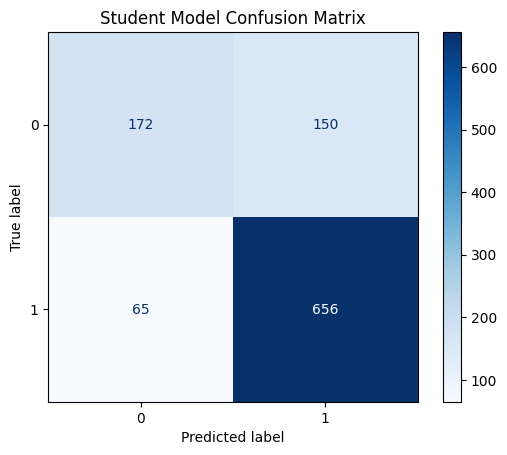

Classification Report:

              precision    recall  f1-score   support

           0     0.7257    0.5342    0.6154       322
           1     0.8139    0.9098    0.8592       721

    accuracy                         0.7939      1043
   macro avg     0.7698    0.7220    0.7373      1043
weighted avg     0.7867    0.7939    0.7839      1043

| Model   |   matthews_corrcoef |   accuracy |   precision |   recall |       f1 |   avg_inference_time |
|:--------|--------------------:|-----------:|------------:|---------:|---------:|---------------------:|
| Student |            0.489492 |   0.793864 |    0.813896 | 0.909847 | 0.859201 |           0.00465984 |
| Teacher |            0.572797 |   0.826462 |    0.829268 | 0.943135 | 0.882544 |           0.00919466 |
Saved CSV to /content/drive/MyDrive/CS4782FinalProject/final_train/cola_finetune_final/eval/cola_comparison.csv


In [ ]:
###################### Student Confusion Matrix and Report #####################

student_cola_confusion_matrix = student_cola_results["confusion_matrix"]
student_cola_report = student_cola_results["report"]
cola_cm_matrix_path = os.path.join(cola_eval_path, "cola_confusion_matrix.png")
os.makedirs(os.path.dirname(cola_cm_matrix_path), exist_ok=True)

disp = ConfusionMatrixDisplay(confusion_matrix=student_cola_confusion_matrix)
disp.plot(cmap="Blues")
plt.title("Student Model Confusion Matrix")
plt.savefig(cola_cm_matrix_path)
plt.show()

print("Classification Report:\n")
print(student_cola_report)

classification_report_path = os.path.join(cola_eval_path, "student_classification_report_cola.txt")
with open(classification_report_path, "w") as f:
    f.write(student_cola_report)

################################################################################

################################## Comparsion ##################################
cola_comparison_df = pd.DataFrame([
    {
        "Model": "Student",
        **student_cola_results,
    },
    {
        "Model": "Teacher",
        **teacher_cola_results,
    }
])

cola_comparison_df = cola_comparison_df[[
    "Model",
    "matthews_corrcoef",
    "accuracy",
    "precision",
    "recall",
    "f1",
    "avg_inference_time"
]]

print(cola_comparison_df.to_markdown(index=False))

cola_comparsion_df_save_path = os.path.join(cola_eval_path, "cola_comparison.csv")
cola_comparison_df.to_csv(cola_comparsion_df_save_path, index=False)
print(f"Saved CSV to {cola_comparsion_df_save_path}")

################################################################################

### Finetune for MRPC Dataset

In [ ]:
mrpc_path = os.path.join(save_path, "mrpc_finetune_final")

In [ ]:
mrpc = load_dataset("glue", "mrpc")

tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)

def preprocess(example):
    return tokenizer(
        example["sentence1"],
        example["sentence2"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

encoded_mrpc = mrpc.map(preprocess, batched=True)
encoded_mrpc.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

data_collator = DataCollatorWithPadding(tokenizer)

train_loader = DataLoader(encoded_mrpc["train"], shuffle=True, batch_size=config.batch_size, collate_fn=data_collator)
test_loader = DataLoader(encoded_mrpc["validation"], batch_size=config.batch_size, collate_fn=data_collator)

train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [ ]:
student_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2).to(config.device)

training_args = TrainingArguments(
    output_dir=os.path.join(mrpc_path, "results-student"),
    eval_strategy="epoch",
    learning_rate=config.learning_rate,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    num_train_epochs=config.epochs,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir=os.path.join(mrpc_path, "logs-student"),
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=encoded_mrpc["train"],
    eval_dataset=encoded_mrpc["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

student_mrpc_path = os.path.join(mrpc_path, "student_model")
student_model.save_pretrained(student_mrpc_path)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/CS4782FinalProject/final_train/final_distilled_student_model_wikitext and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-32-ec9f95f4cdbf>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.532900,0.455362
2,0.374100,0.376346
3,0.278700,0.401592


In [ ]:
teacher_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(config.device)

training_args = TrainingArguments(
    output_dir=os.path.join(mrpc_path, "results-teacher"),
    eval_strategy="epoch",
    learning_rate=config.learning_rate,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    num_train_epochs=config.epochs,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir=os.path.join(mrpc_path, "logs-teacher"),
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=teacher_model,
    args=training_args,
    train_dataset=encoded_mrpc["train"],
    eval_dataset=encoded_mrpc["validation"],
    tokenizer=tokenizer,  # student tokenizer
    data_collator=data_collator,
)

trainer.train()

teacher_mrpc_path = os.path.join(mrpc_path, "teacher_model")
teacher_model.save_pretrained(teacher_mrpc_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-33-42400a6beac8>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.508300,0.391188
2,0.336600,0.373368
3,0.206300,0.399515


### MRPC Evaluation

In [ ]:
mrpc_eval_path = os.path.join(mrpc_path, "eval")

student_mrpc_path = os.path.join(mrpc_path,"student_model")
teacher_mrpc_path = os.path.join(mrpc_path,"teacher_model")

student = AutoModelForSequenceClassification.from_pretrained(student_mrpc_path).to(config.device)
teacher = AutoModelForSequenceClassification.from_pretrained(teacher_mrpc_path).to(config.device)
tokenizer = AutoTokenizer.from_pretrained(model_path)

student_mrpc_results = evaluate_model(student, test_loader)
teacher_mrpc_results = evaluate_model(teacher, test_loader)

In [ ]:
################################### Accuracy ###################################

student_mrpc_acc = student_mrpc_results["accuracy"]
teacher_mrpc_acc = teacher_mrpc_results["accuracy"]

mrpc_acc_retained_pct = 100 * student_mrpc_acc / teacher_mrpc_acc

print(f"Teacher Accuracy: {teacher_mrpc_acc:.4f}")
print(f"Student Accuracy: {student_mrpc_acc:.4f}")
print(f"Student retained {mrpc_acc_retained_pct:.2f}% of teacher's performance.")

################################################################################

Teacher Accuracy: 0.8505
Student Accuracy: 0.8382
Student retained 98.56% of teacher's performance.


In [ ]:
########################## Speed Up and Inference Time #########################

student_mrpc_inference_time = student_mrpc_results["avg_inference_time"]
teacher_mrpc_inference_time = teacher_mrpc_results["avg_inference_time"]

print(f"Student Avg Inference Time: {student_mrpc_inference_time*1000:.2f} ms")
print(f"Teacher Avg Inference Time: {teacher_mrpc_inference_time*1000:.2f} ms")

mrpc_speedup = teacher_mrpc_inference_time / student_mrpc_inference_time
print(f"Speedup: {mrpc_speedup:.2f}x faster")
################################################################################

Student Avg Inference Time: 15.61 ms
Teacher Avg Inference Time: 60.13 ms
Speedup: 3.85x faster


In [ ]:
############################### F1-Accuracy Average ############################

student_mrpc_f1_acc_avg = student_mrpc_results["f1_acc_avg"]
teacher_mrpc_f1_acc_avg = teacher_mrpc_results["f1_acc_avg"]

mrpc_f1_acc_retained_pct = 100 * student_mrpc_f1_acc_avg / teacher_mrpc_f1_acc_avg if teacher_mrpc_f1_acc_avg != 0 else 0

print(f"Teacher F1/Accuracy: {teacher_mrpc_f1_acc_avg:.4f}")
print(f"Student F1/Accuracy: {student_mrpc_f1_acc_avg:.4f}")
print(f"Student retained {mrpc_f1_acc_retained_pct:.2f}% of teacher's F1/Accuracy performance.")
################################################################################

Teacher F1/Accuracy: 0.8716
Student F1/Accuracy: 0.8616
Student retained 98.85% of teacher's F1/Accuracy performance.


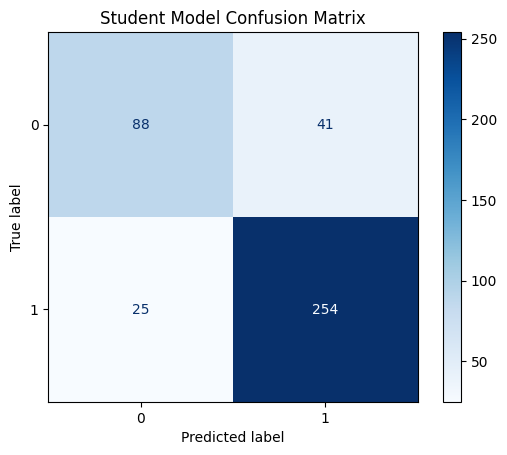

Classification Report:

              precision    recall  f1-score   support

           0     0.7788    0.6822    0.7273       129
           1     0.8610    0.9104    0.8850       279

    accuracy                         0.8382       408
   macro avg     0.8199    0.7963    0.8061       408
weighted avg     0.8350    0.8382    0.8351       408

| Model   |   accuracy |   precision |   recall |       f1 |   f1_acc_avg |   avg_inference_time |
|:--------|-----------:|------------:|---------:|---------:|-------------:|---------------------:|
| Student |   0.838235 |    0.861017 | 0.910394 | 0.885017 |     0.861626 |            0.0156079 |
| Teacher |   0.85049  |    0.875862 | 0.910394 | 0.892794 |     0.871642 |            0.0601267 |
Saved CSV to /content/drive/MyDrive/CS4782FinalProject/final_train/mrpc_finetune_final/eval/mrpc_comparison.csv


In [ ]:
###################### Student Confusion Matrix and Report #####################

student_mrpc_confusion_matrix = student_mrpc_results["confusion_matrix"]
student_mrpc_report = student_mrpc_results["report"]
mrpc_cm_matrix_path = os.path.join(mrpc_eval_path, "mrpc_confusion_matrix.png")
os.makedirs(os.path.dirname(mrpc_cm_matrix_path), exist_ok=True)

disp = ConfusionMatrixDisplay(confusion_matrix=student_mrpc_confusion_matrix)
disp.plot(cmap="Blues")
plt.title("Student Model Confusion Matrix")
plt.savefig(mrpc_cm_matrix_path)
plt.show()

print("Classification Report:\n")
print(student_mrpc_report)

classification_report_path = os.path.join(mrpc_eval_path, "student_classification_report_mrpc.txt")
with open(classification_report_path, "w") as f:
    f.write(student_mrpc_report)

################################################################################

################################## Comparsion ##################################
mrpc_comparison_df = pd.DataFrame([
    {
        "Model": "Student",
        **student_mrpc_results,
    },
    {
        "Model": "Teacher",
        **teacher_mrpc_results,
    }
])

mrpc_comparison_df = mrpc_comparison_df[[
    "Model",
    "accuracy",
    "precision",
    "recall",
    "f1",
    "f1_acc_avg",
    "avg_inference_time"
]]

print(mrpc_comparison_df.to_markdown(index=False))

mrpc_comparsion_df_save_path = os.path.join(mrpc_eval_path, "mrpc_comparison.csv")
mrpc_comparison_df.to_csv(mrpc_comparsion_df_save_path, index=False)
print(f"Saved CSV to {mrpc_comparsion_df_save_path}")

################################################################################

# Overall Model Evaluation and Paper Comparsion

In [ ]:
distilbert_imdb_paper_results = {
    "Model": "DistilBERT-IMDB",
    "score": 92.82,
}

bert_imdb_paper_results = {
    "Model": "BERT-IMDB",
    "score": 93.46,
}

distilbert_cola_paper_results = {
    "Model": "DistilBERT-CoLA",
    "score": 51.3,
}

bert_cola_paper_results = {
    "Model": "BERT-CoLA",
    "score": 56.3,
}

distilbert_mrpc_paper_results = {
    "Model": "DistilBERT-MRPC",
    "score": 87.5,
}

bert_mrpc_paper_results = {
    "Model": "BERT-MRPC",
    "score": 88.6,
}

distilbert_imdb_our_results = {
    "Model": "Our DistilBERT-IMDB",
    "score": student_imdb_acc*100,
}

bert_imdb_our_results = {
    "Model": "Our BERT-IMDB",
    "score": teacher_imdb_acc*100,
}

distilbert_cola_our_results = {
    "Model": "Our DistilBERT-CoLA",
    "score": student_cola_mcc*100,
}

bert_cola_our_results = {
    "Model": "Our BERT-CoLA",
    "score": teacher_cola_mcc*100,
}

distilbert_mrpc_our_results = {
    "Model": "Our DistilBERT-MRPC",
    "score": student_mrpc_f1_acc_avg*100,
}

bert_mrpc_our_results = {
    "Model": "Our BERT-MRPC",
    "score": teacher_mrpc_f1_acc_avg*100,
}

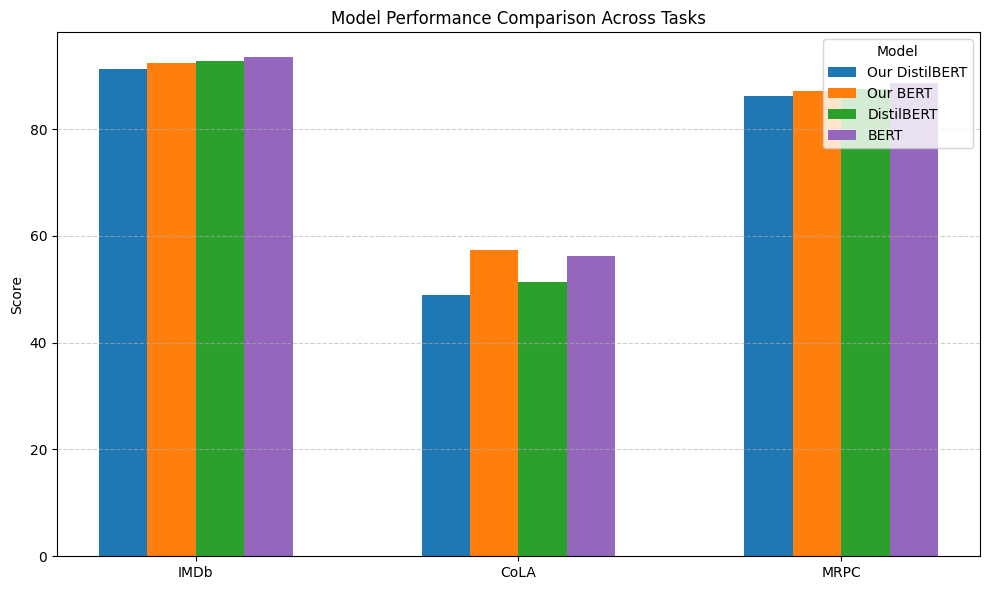

In [ ]:
def plot_comparisons(imdb_results, cola_results, mrpc_results):
    all_results = []

    for task_name, results in [
        ("IMDb", imdb_results),
        ("CoLA", cola_results),
        ("MRPC", mrpc_results),
    ]:
        for r in results:
            all_results.append({
                "Task": task_name,
                "Model": r["Model"],
                "Score": r["score"]
            })

    df = pd.DataFrame(all_results)

    base_models = {
        "Our DistilBERT": "#1f77b4",
        "Our BERT": "#ff7f0e",
        "DistilBERT": "#2ca02c",
        "BERT": "#9467bd",
    }

    def clean_model_label(model_str):
        if "Our DistilBERT" in model_str:
            return "Our DistilBERT"
        elif "Our BERT" in model_str:
            return "Our BERT"
        elif "DistilBERT" in model_str:
            return "DistilBERT"
        elif "BERT" in model_str:
            return "BERT"
        else:
            return model_str

    df["BaseModel"] = df["Model"].apply(clean_model_label)

    tasks = df["Task"].unique()
    models = df["BaseModel"].unique()
    n_models = len(models)
    x = np.arange(len(tasks))
    bar_width = 0.15

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, model in enumerate(models):
        model_data = df[df["BaseModel"] == model]
        scores = [model_data[model_data["Task"] == task]["Score"].values[0] for task in tasks]
        offsets = x + (i - n_models / 2) * bar_width + bar_width / 2

        ax.bar(offsets, scores, width=bar_width, label=model, color=base_models[model])

    ax.set_xticks(x)
    ax.set_xticklabels(tasks)
    ax.set_ylabel("Score")
    ax.set_title("Model Performance Comparison Across Tasks")
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.legend(title="Model", loc="upper right")
    plt.tight_layout()

    plot_path = os.path.join(save_path,"performance_comparison_final.png")
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    plt.show()

plot_comparisons(
    imdb_results=[
        distilbert_imdb_our_results,
        bert_imdb_our_results,
        distilbert_imdb_paper_results,
        bert_imdb_paper_results
    ],
    cola_results=[
        distilbert_cola_our_results,
        bert_cola_our_results,
        distilbert_cola_paper_results,
        bert_cola_paper_results
    ],
    mrpc_results=[
        distilbert_mrpc_our_results,
        bert_mrpc_our_results,
        distilbert_mrpc_paper_results,
        bert_mrpc_paper_results
    ]
)

In [ ]:
################################### Benchmark ##################################
benchmark_retained_pct = (cola_mcc_retained_pct + mrpc_f1_acc_retained_pct + imdb_acc_retained_pct )/3

print(f"Student retained {benchmark_retained_pct:.2f}% of teacher's performance.")

################################################################################

Student retained 94.35% of teacher's performance.


In [ ]:
########################## Speed Up and Inference Time #########################
avg_speedup = (cola_speedup + mrpc_speedup + imdb_speedup)/3

print(f"Speedup: {avg_speedup:.2f}x faster")
################################################################################

Speedup: 2.61x faster
